# Покупательская активность магазина "В один клик"

В распоряжении 4 датасета:
- market_file.csv - данные о продуктовом поведении покупателя на сайте и коммуникациях магазина с ним.
- market_money.csv - данные о выручке, которую получает магазин с покупателя.
- market_time.csv - данные о времени, которое покупатель провёл на сайте в течение периода.
- money.csv - данные о среднемесячной прибыли покупателя за последние 3 месяца.

Бизнес-запрос:

Необходимо разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Цель проекта:
- Построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
- Выделить сегменты покупателей и разработать для них персонализированные предложения, чтобы увеличить их покупательскую активность.

Ход проекта:

Необходимые данные в датасетах market_file.csv, market_money.csv, market_time.csv и money.csv. О состоянии и качестве данных ничего не известно, поэтому сначала нужно прочитать файлы с помощью Pandas и изучить общую информацию.

Предобработка данных:
- Если будут проблемы с наименованием столбцов, то их нужно переименовать, чтобы привести к удобным и читаемым названиям.
- Проверить на явные дубликаты и если такие имеются, то удалить.
- Проверить на наличие пропусков и обработать их.
- Если будет необходимость, то исправить типы данных
- Обработать неявные дубликаты.

Исследовательский анализ данных:
- Провести исследовательский анализ данных из каждой таблицы.
- Отобрать клиентов с покупательской активностью не менее трёх месяцев.
- Сделать выводы по результатам исследования.

Объединение таблиц:
- Объединить таблицы market_file.csv, market_money.csv, market_time.csv.
- В итоговой таблице сделать отдельный столбец для каждого периода по данным о выручке.

Корреляционный анализ:
- Провести корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования.
- Сделать выводы о мультиколлинеарности и при необходимости устранить её.

Использование пайплайнов:
- Применить 4 модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC().
- Выбрать подходящую для задачи метрику и использовать её при подборе гиперпараметров.
- Выбрать лучшую модель, ориентируясь на заданную метрику.

Анализ важности признаков:
- Оценить важность признаков для лучшей модели и построить график важности с помощью метода SHAP.
- Сделать выводы о значимости признаков.

Сегментация покупателей:
- Выполнить сегментацию покупателей, используя результаты моделирования и данные о прибыльности покупателей.
- Выбрать группу покупателей и предложить, как увеличить их покупательскую активность.
- Сделать выводы о сегментах.

Общий вывод:
- Подвести итоги проекта, описать задачу, исходные данные и проведённую предобработку.
- Описать, что было сделано для поиска лучшей модели.
- Указать лучшую модель.
- Добавить выводы и дополнительные предложения для выбранного сегмента покупателей.

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import phik
import shap

from scipy import stats as st
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV
)
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
    RobustScaler
)
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    accuracy_score,
    f1_score,
    roc_auc_score
)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
warnings.filterwarnings("ignore")

In [3]:
market_data = pd.read_csv('./datasets/market_file.csv')
market_money_data = pd.read_csv('./datasets/market_money.csv')
market_time_data = pd.read_csv('./datasets/market_time.csv')
money_data = pd.read_csv('./datasets/money.csv', sep=';', decimal = ',')

Первые строки каждого датасета и общая информация о них.

In [4]:
display(market_data.head())
market_data.info()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [5]:
display(market_money_data.head())
market_money_data.info()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [6]:
display(market_time_data.head())
market_time_data.info()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [7]:
display(money_data.head())
money_data.info()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Датасеты читаются корректно, все необходимые данные загружены. Названия столбцов во всех датасетах нужно изменить, так как они не соответствуют стандарту snake_case и на русском языке. Из общей информации о данных видно, что пропусков нет, типы данных также корректны.

## Предобработка данных

### Изменение названий столбцов

In [8]:
market_data = market_data.rename(
    columns={
        'Покупательская активность': 'activity',
        'Тип сервиса': 'service_type',
        'Разрешить сообщать': 'newsletter',
        'Маркет_актив_6_мес': 'marketing_activity_half_year',
        'Маркет_актив_тек_мес': 'marketing_activity_current_month',
        'Длительность': 'days_from_registration',
        'Акционные_покупки': 'promo_purchases',
        'Популярная_категория': 'popular_category',
        'Средний_просмотр_категорий_за_визит': 'average_category_views_per_visit',
        'Неоплаченные_продукты_штук_квартал': 'unpaid_cart_products_quarter',
        'Ошибка_сервиса': 'service_errors_count',
        'Страниц_за_визит': 'page_views_per_visit'
    }
)

market_money_data = market_money_data.rename(
    columns={
        'Период': 'period',
        'Выручка': 'revenue'
    }
)

market_time_data = market_time_data.rename(
    columns={
        'Период': 'period',
        'минут': 'minutes'
    }
)

money_data = money_data.rename(
    columns={
        'Прибыль': 'profit'
    }
)

Проверим, что название столбцов изменились корректно.

In [9]:
display(market_data.info())
display(market_money_data.info())
display(market_time_data.info())
money_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                1300 non-null   int64  
 1   activity                          1300 non-null   object 
 2   service_type                      1300 non-null   object 
 3   newsletter                        1300 non-null   object 
 4   marketing_activity_half_year      1300 non-null   float64
 5   marketing_activity_current_month  1300 non-null   int64  
 6   days_from_registration            1300 non-null   int64  
 7   promo_purchases                   1300 non-null   float64
 8   popular_category                  1300 non-null   object 
 9   average_category_views_per_visit  1300 non-null   int64  
 10  unpaid_cart_products_quarter      1300 non-null   int64  
 11  service_errors_count              1300 non-null   int64  
 12  page_v

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   period   3900 non-null   object 
 2   revenue  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       2600 non-null   int64 
 1   period   2600 non-null   object
 2   minutes  2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      1300 non-null   int64  
 1   profit  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


### Проверка на дубликаты

Для начала приведём все данные к нижнему регистру, чтобы избежать дубликатов из-за разных регистров.

In [10]:
market_data = market_data.apply(lambda x: x.str.lower() if x.dtype == 'object' else x)
market_money_data = market_money_data.apply(lambda x: x.str.lower() if x.dtype == 'object' else x)
market_time_data = market_time_data.apply(lambda x: x.str.lower() if x.dtype == 'object' else x)

Проверим все ли строковые значения теперь в нижнем регистре, также посмотрим на уникальные значения в этих столбцах.

In [11]:
for column in market_data.select_dtypes(include='object').columns:
    print(column)
    print(market_data[column].unique())
    print()

print('period (market_money_data)')
print(market_money_data['period'].unique())
print()
print('period (market_time_data)')
print(market_time_data['period'].unique())

activity
['снизилась' 'прежний уровень']

service_type
['премиум' 'стандартт' 'стандарт']

newsletter
['да' 'нет']

popular_category
['товары для детей' 'домашний текстиль' 'косметика и аксесуары'
 'техника для красоты и здоровья' 'кухонная посуда'
 'мелкая бытовая техника и электроника']

period (market_money_data)
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']

period (market_time_data)
['текущий_месяц' 'предыдцщий_месяц']


В столбцах есть дубликаты из-за неправильного написания слов и банальные опечатки.
Исправлю это, чтобы искать дубликаты корректно.
Также исправление опечаток поможет для дальнейшей работы модели. Может случиться так, что из-за опечаток модель некорректно обучится и будет ошибаться, когда ей дадут на вход данные без опечаток.

In [12]:
market_data['service_type'] = market_data['service_type'].replace('стандартт', 'стандарт')
market_data['popular_category'] = market_data['popular_category'].replace('косметика и аксесуары', 'косметика и аксессуары')
market_time_data['period'] = market_time_data['period'].replace('предыдцщий_месяц', 'предыдущий_месяц')

Проверим на явные дубликаты.

In [13]:
print('Количество дубликатов в market_data:', market_data.duplicated().sum())
print('Количество дубликатов в market_money_data:', market_money_data.duplicated().sum())
print('Количество дубликатов в market_time_data:', market_time_data.duplicated().sum())
print('Количество дубликатов в money_data:', money_data.duplicated().sum())

Количество дубликатов в market_data: 0
Количество дубликатов в market_money_data: 0
Количество дубликатов в market_time_data: 0
Количество дубликатов в money_data: 0


### Вывод по предобработке данных

- Названия столбцов были приведены к snake_case и переведены на английский язык.
- Все строковые значения были приведены к нижнему регистру.
- В датасетах были исправлены опечатки и неправильные написания слов, тем самым были устранены неявные дубликаты.
- Явные дубликаты в данных отсутствуют.
- Пропусков в данных нет.
- Типы данных в столбцах корректны.

## Исследовательский анализ данных

Начну с анализа датасета market_data.

Сначала изучу категориальные признаки. Построю графики, чтобы увидеть распределение данных.

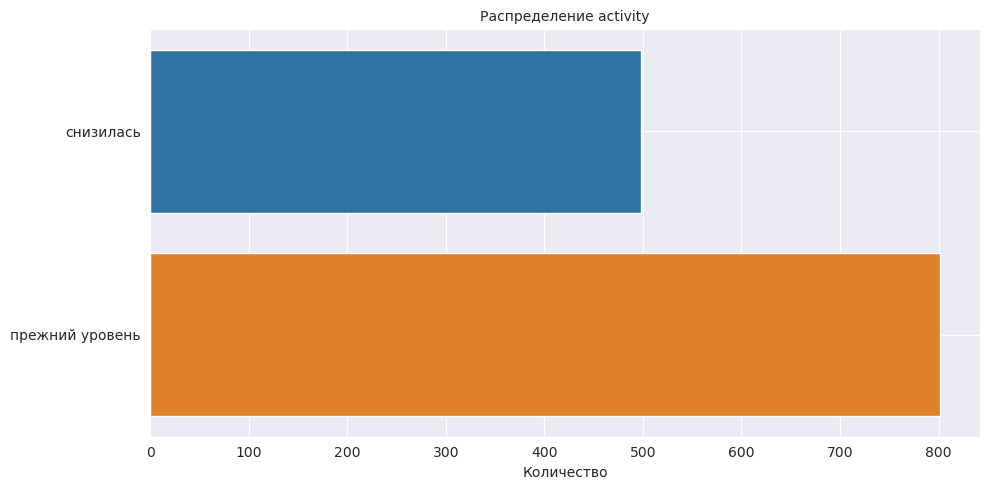

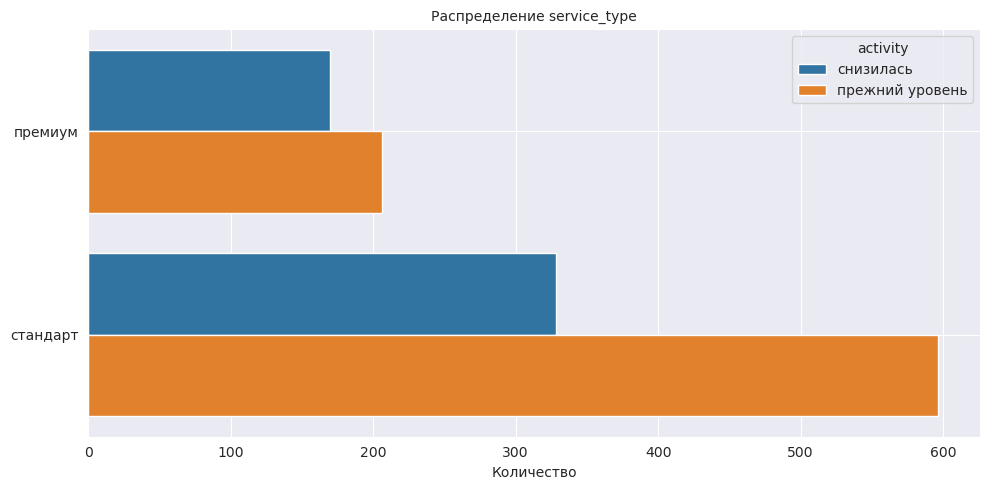

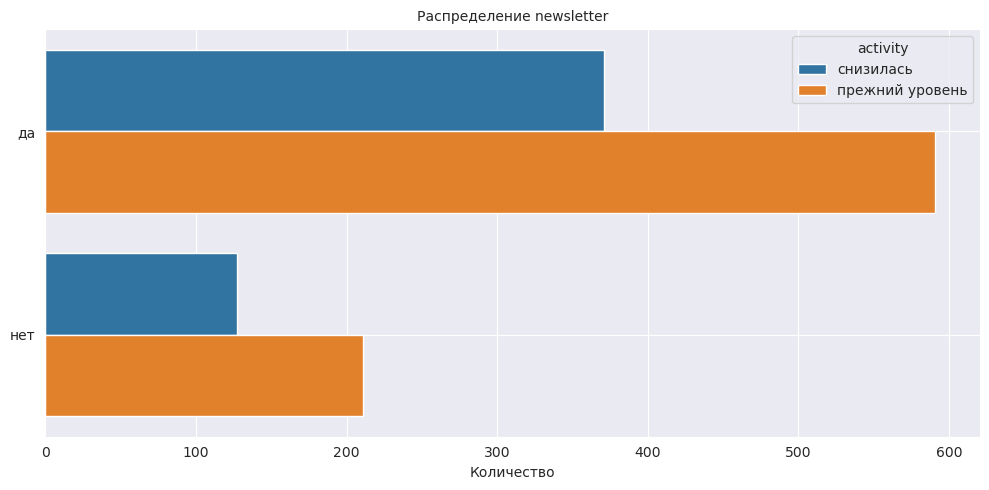

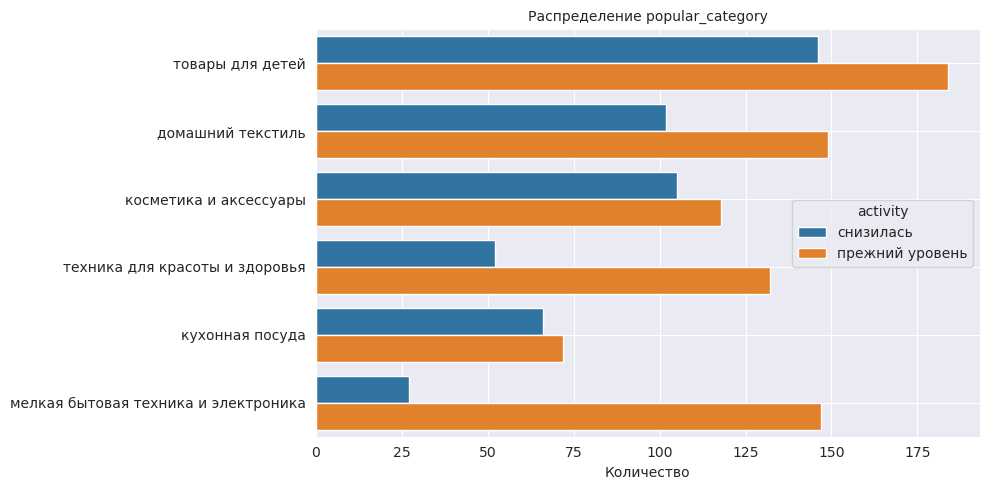

In [14]:
category_columns = market_data.select_dtypes(include='object').columns

for i, column in enumerate(category_columns):
    fig, ax = plt.subplots(figsize=(10, 5))

    if column != 'activity':
        sns.countplot(y=column, hue='activity', data=market_data, ax=ax)
    else:
        sns.countplot(y=column, data=market_data, ax=ax)

    ax.set_title(f'Распределение {column}', fontsize=10)
    ax.set_xlabel('Количество')
    ax.set_ylabel(None)
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

Теперь изучу количественные признаки.

In [15]:
numeric_columns = market_data.select_dtypes(include='number').columns

Выведу общие описание статистик по количественным признакам.

In [16]:
market_data[numeric_columns].describe()

,id,marketing_activity_half_year,marketing_activity_current_month,days_from_registration,promo_purchases,average_category_views_per_visit,unpaid_cart_products_quarter,service_errors_count,page_views_per_visit
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


Построю гистограммы и ящики с усами для количественных признаков.

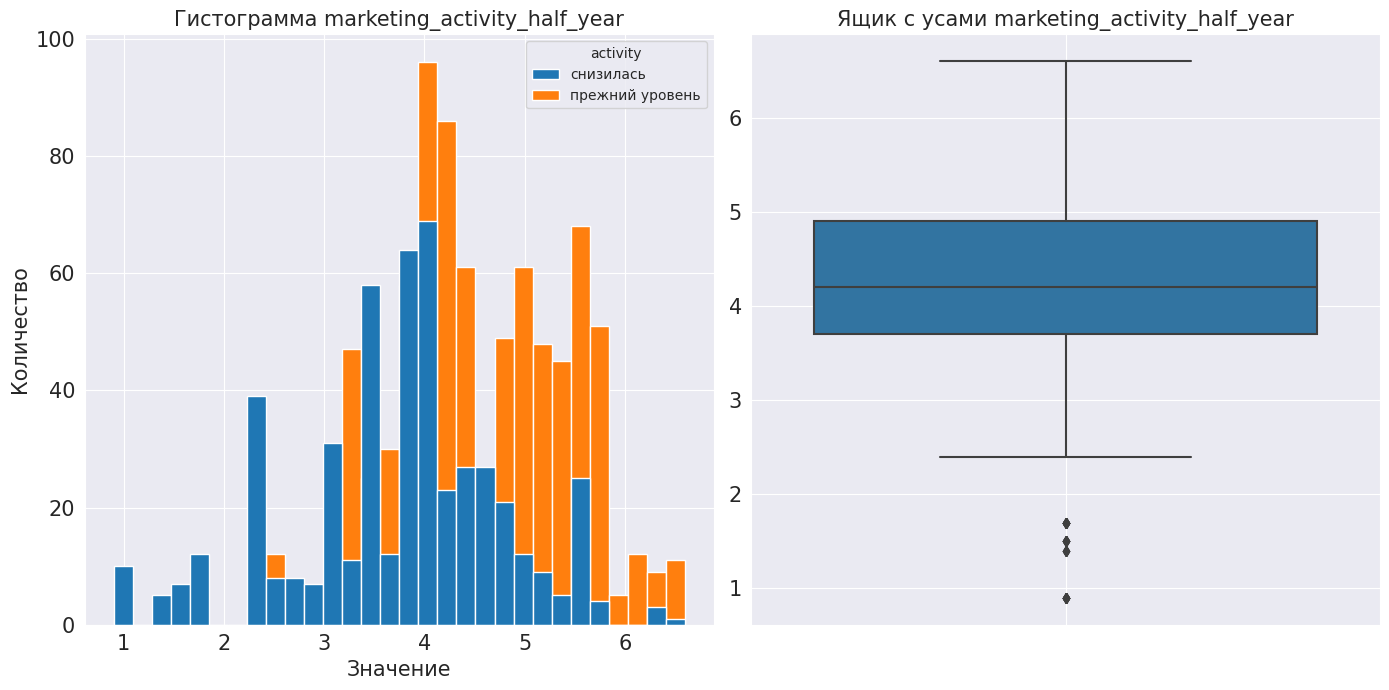

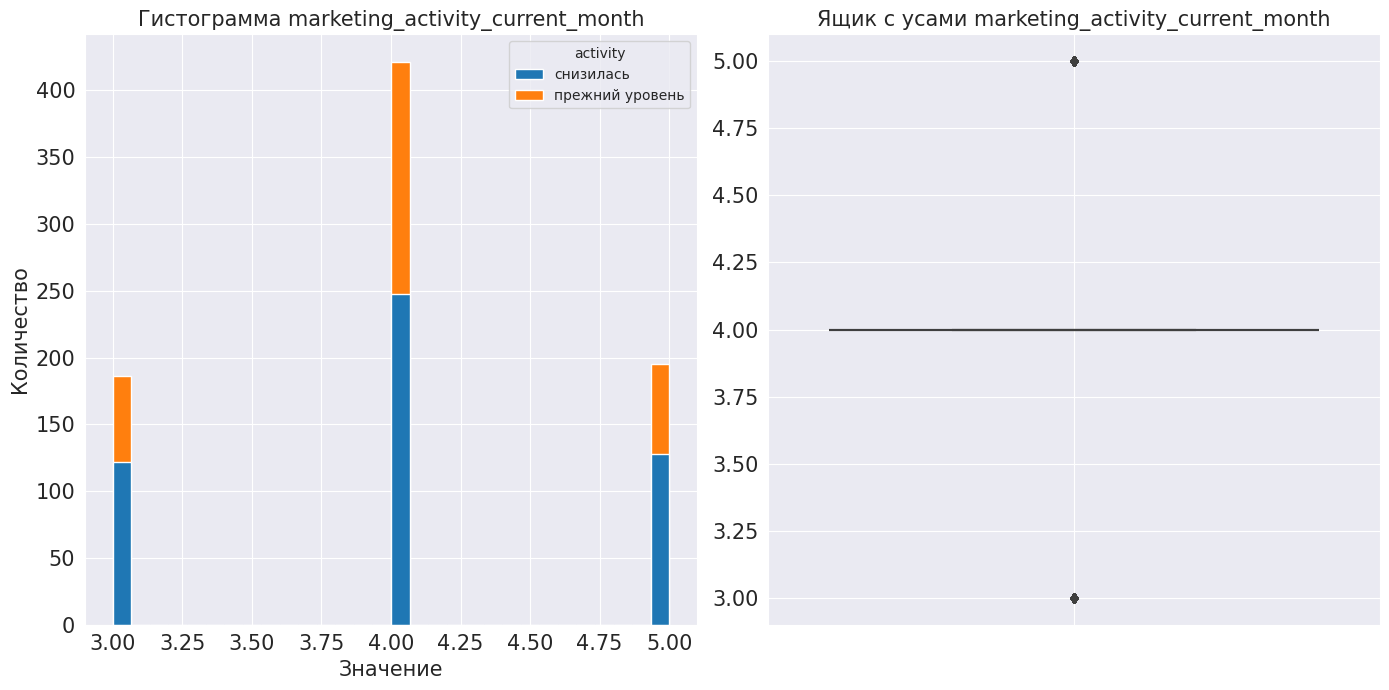

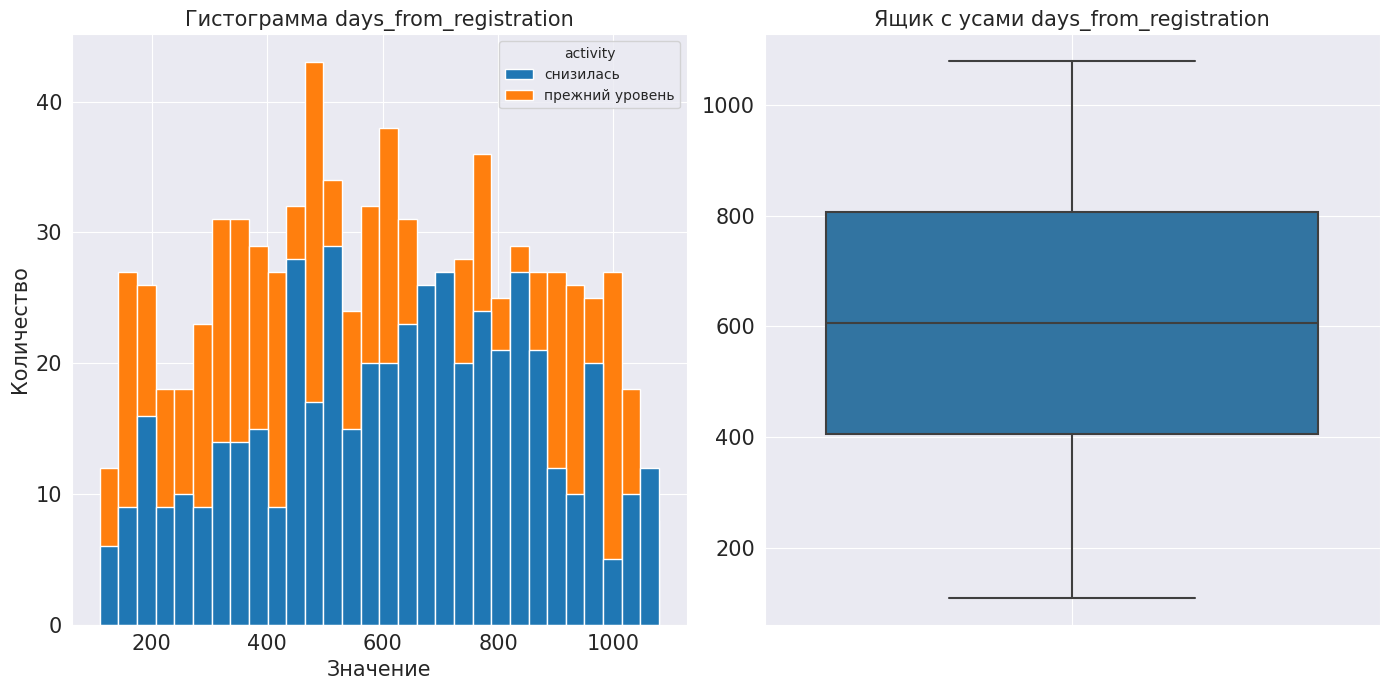

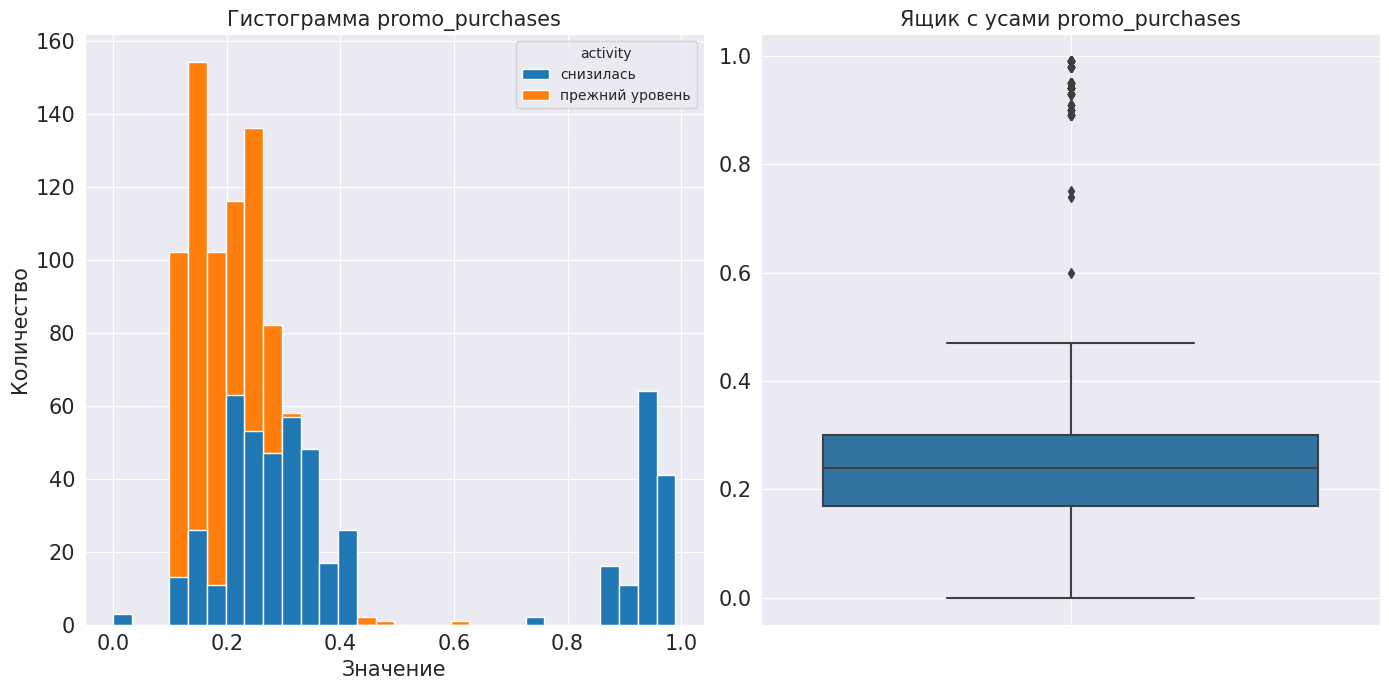

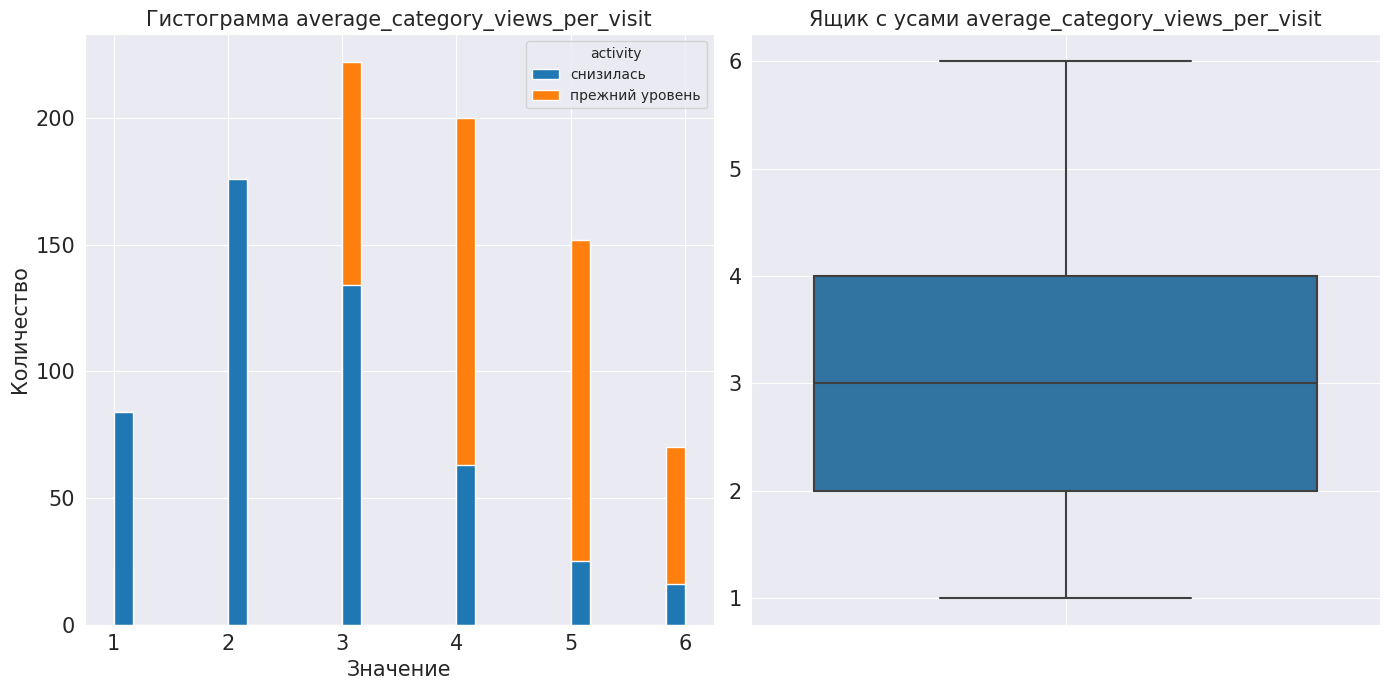

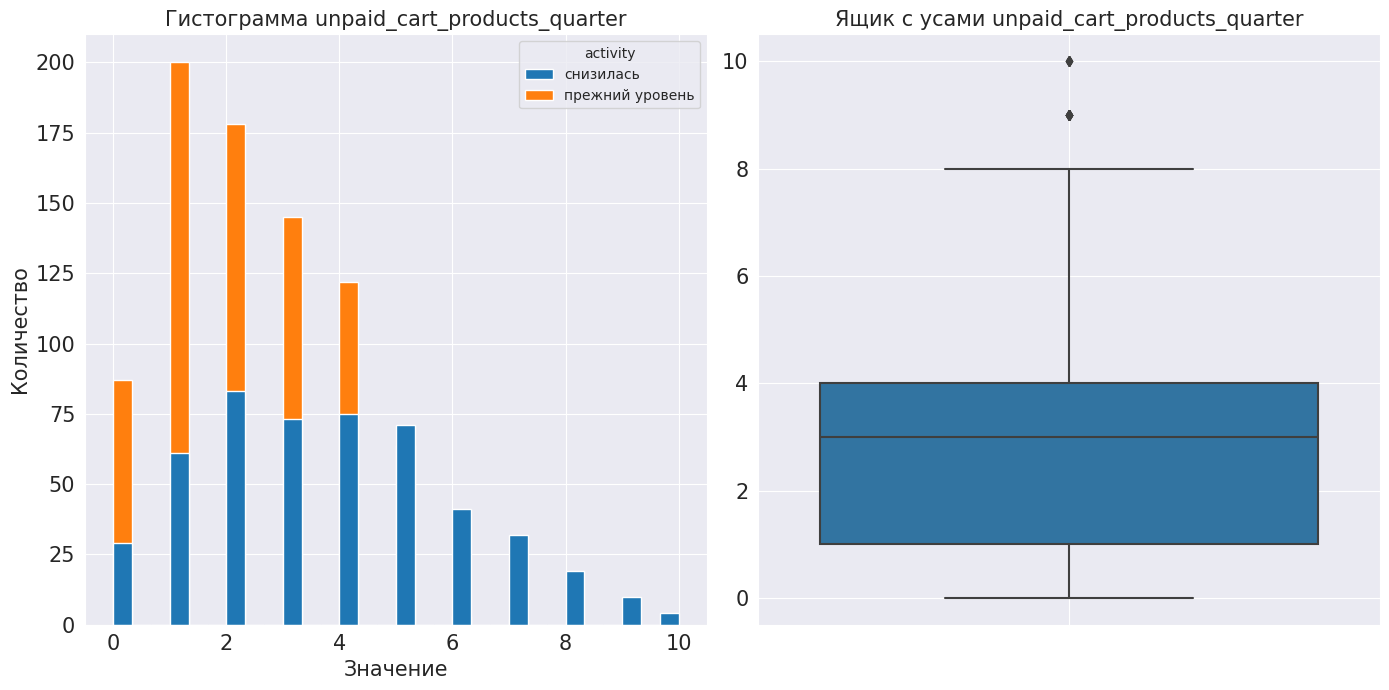

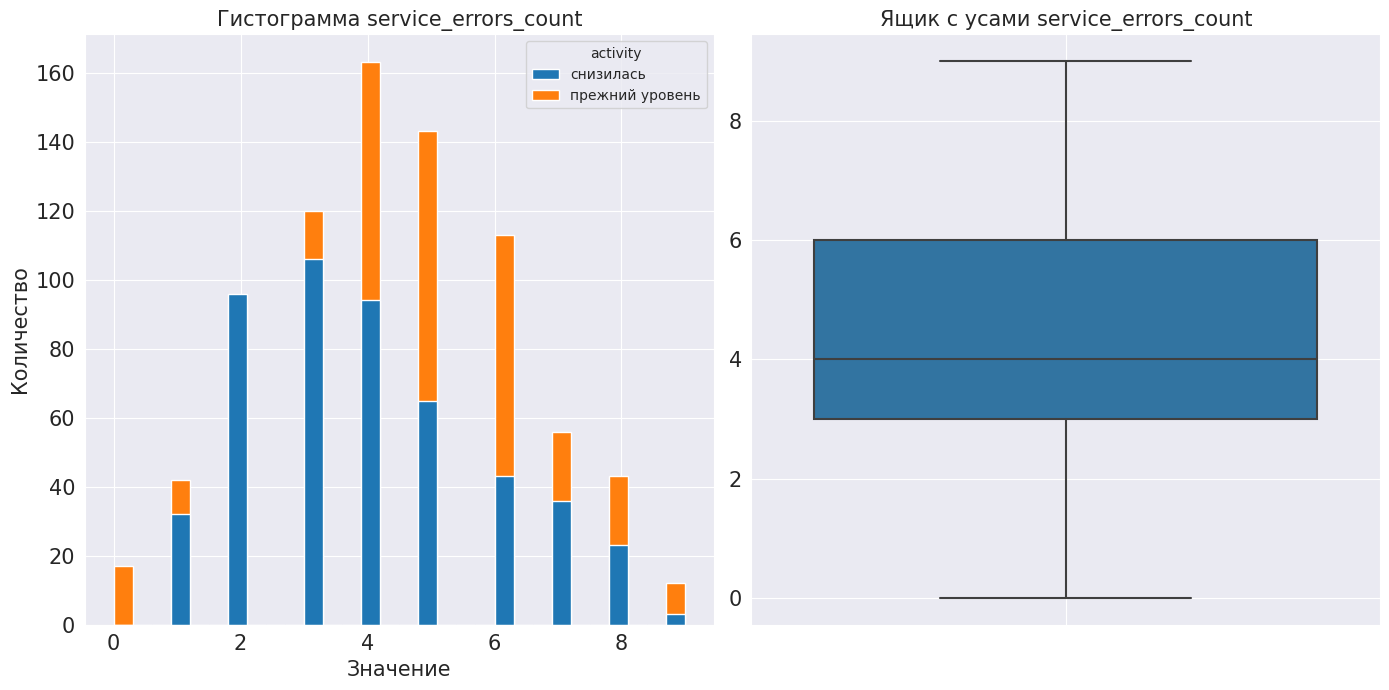

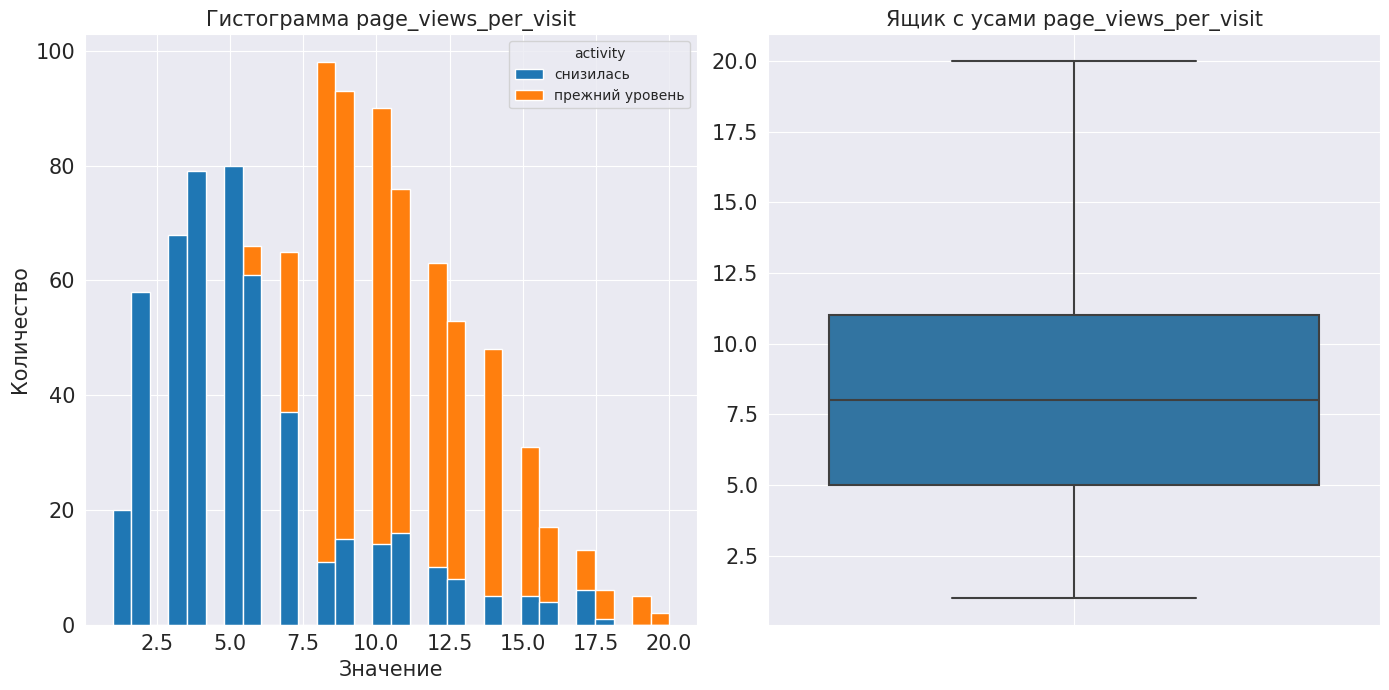

In [18]:
numeric_columns = [col for col in numeric_columns if col != 'id']

for column in numeric_columns:
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))

    sns.histplot(data=market_data, x=column, bins=30, hue='activity', ax=axs[0], alpha=1)
    sns.boxplot(y=market_data[column], ax=axs[1])

    axs[0].set_title(f'Гистограмма {column}', fontsize=15)
    axs[0].set_xlabel('Значение', fontsize=15)
    axs[0].set_ylabel('Количество', fontsize=15)
    axs[0].grid(True)
    axs[0].tick_params(axis='both', which='major', labelsize=15)

    axs[1].set_title(f'Ящик с усами {column}', fontsize=15)
    axs[1].set_ylabel(None)
    axs[1].grid(True)
    axs[1].tick_params(axis='both', which='major', labelsize=15)

    plt.tight_layout()
    plt.show()

Проведу анализ датасета market_money_data.

Так как тут выручка за определённые периоды, то я построю графики для выручки по каждому периоду.

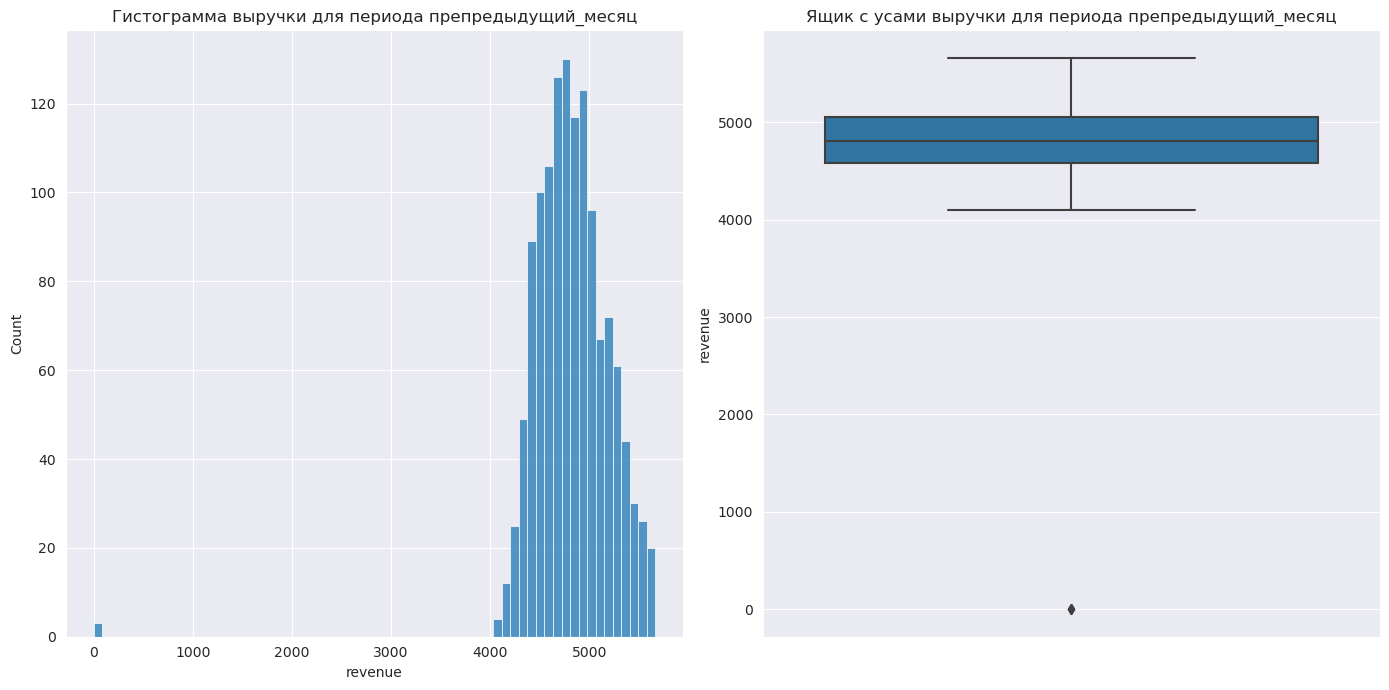

Статистика для периода препредыдущий_месяц:


,revenue
count,1300.000000
mean,4825.206923
std,405.979663
min,0.000000
25%,4583.000000
50%,4809.000000
75%,5053.500000
max,5663.000000


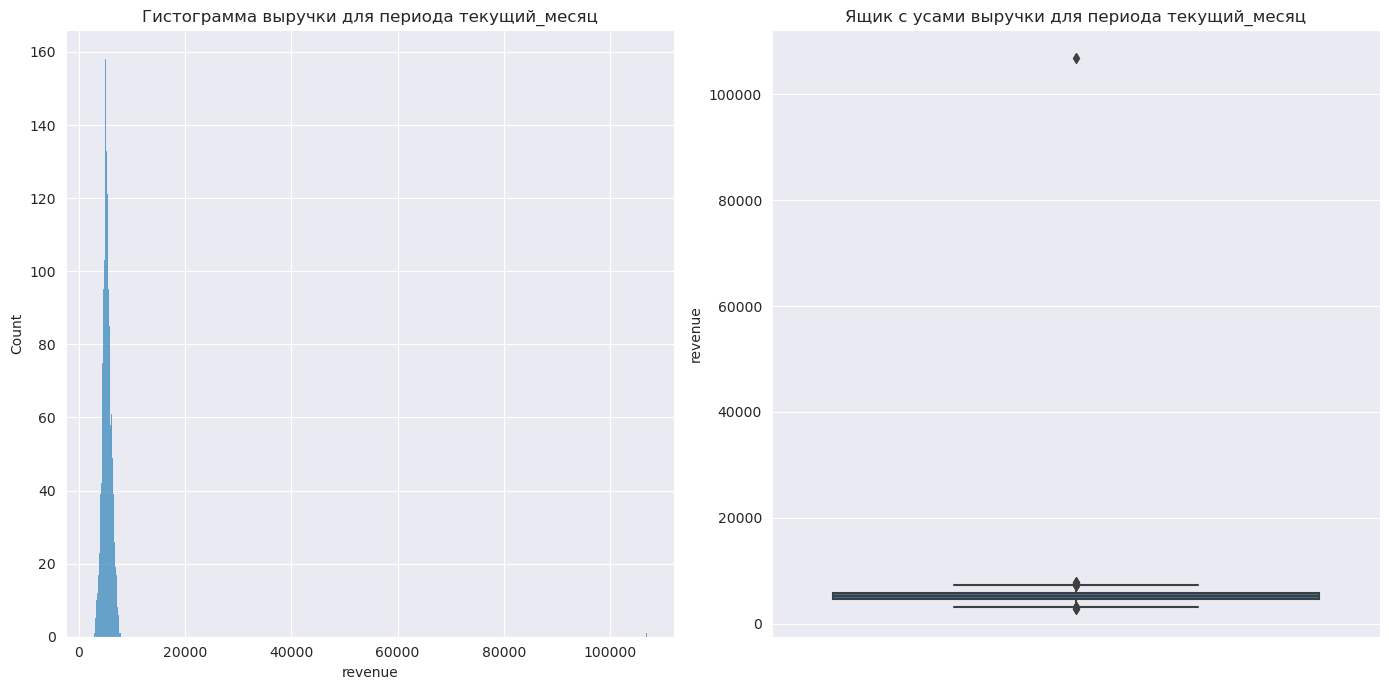

Статистика для периода текущий_месяц:


,revenue
count,1300.000000
mean,5314.960846
std,2939.708156
min,2758.700000
25%,4706.050000
50%,5179.950000
75%,5761.725000
max,106862.200000


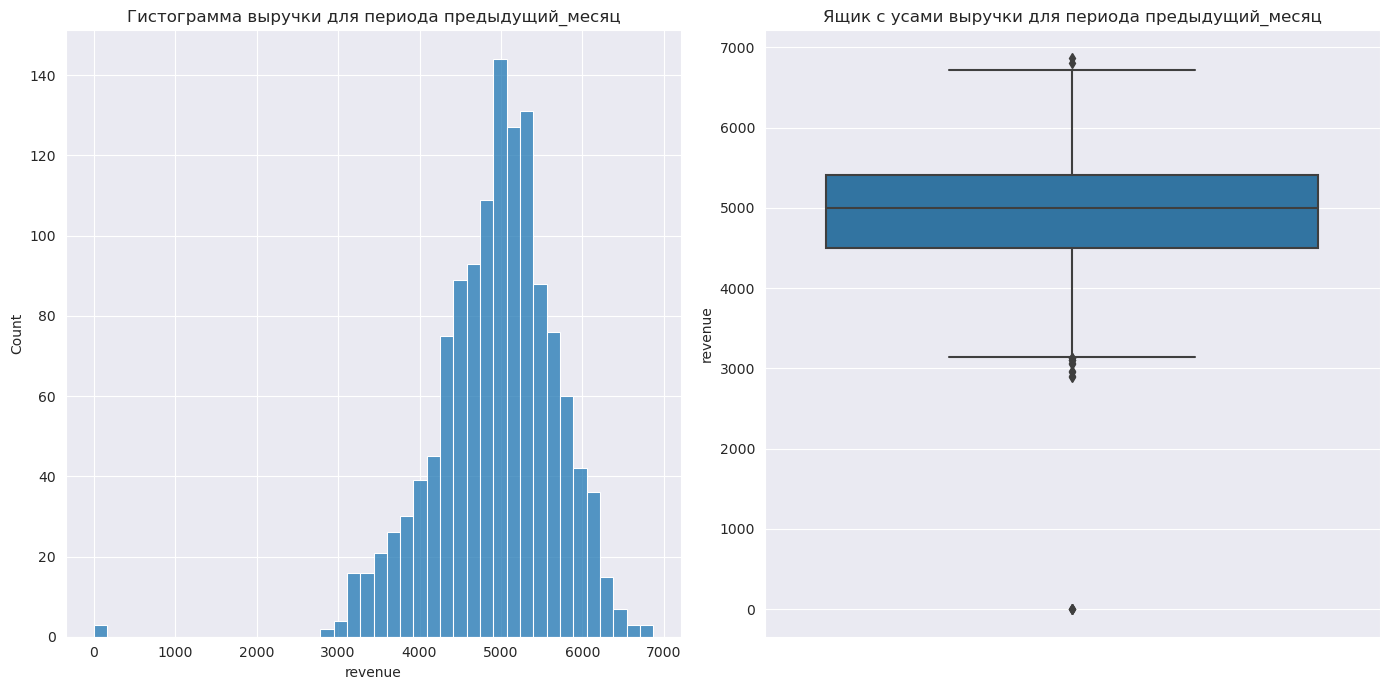

Статистика для периода предыдущий_месяц:


,revenue
count,1300.000000
mean,4936.920385
std,739.597997
min,0.000000
25%,4496.750000
50%,5005.000000
75%,5405.625000
max,6869.500000


In [30]:
periods = market_money_data['period'].unique()

for period in periods:
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))

    data = market_money_data[market_money_data['period'] == period].drop(columns='id')

    sns.histplot(data=data, x='revenue', ax=axs[0])
    axs[0].set_title(f'Гистограмма выручки для периода {period}')

    sns.boxplot(y=data['revenue'], ax=axs[1])
    axs[1].set_title(f'Ящик с усами выручки для периода {period}')

    plt.tight_layout()
    plt.show()

    print(f'Статистика для периода {period}:')
    display(data.describe())

Проведу анализ датасета market_time_data.

Здесь также, как и с выручкой, построю графики для времени на сайте по каждому периоду.

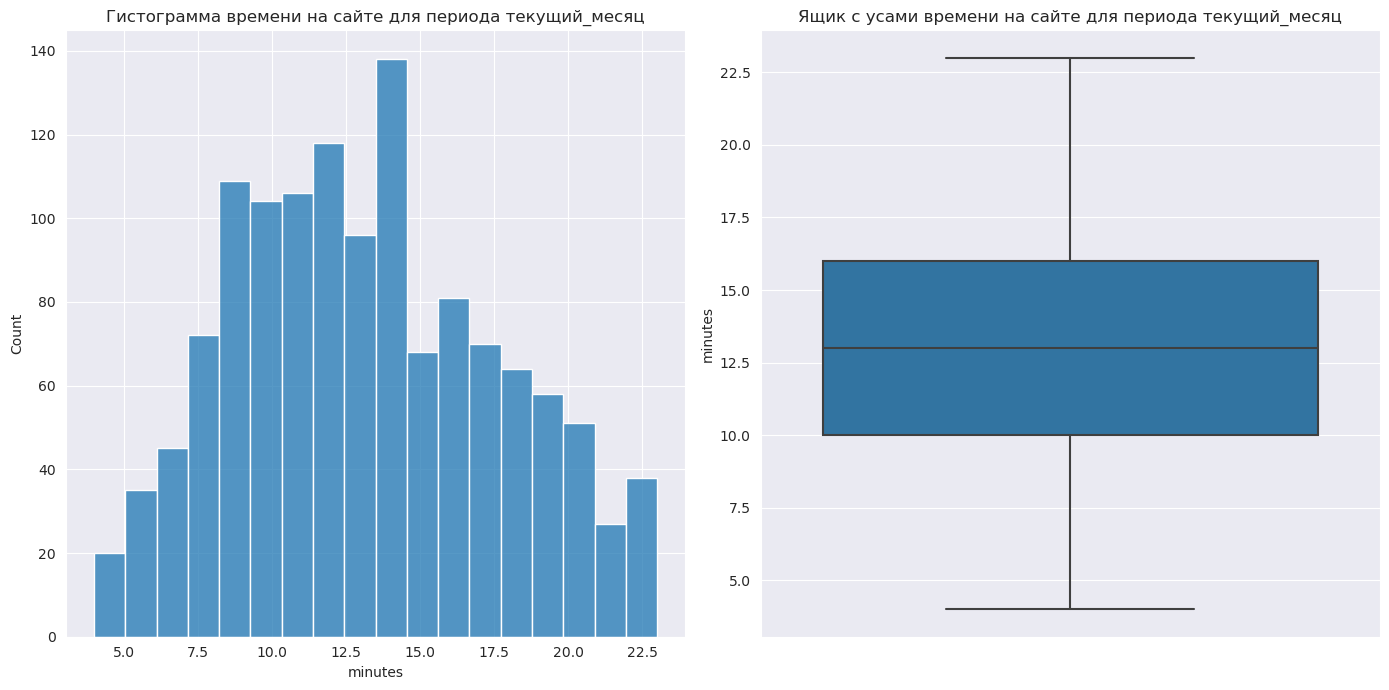

Статистика для периода текущий_месяц:


,minutes
count,1300.000000
mean,13.204615
std,4.220589
min,4.000000
25%,10.000000
50%,13.000000
75%,16.000000
max,23.000000


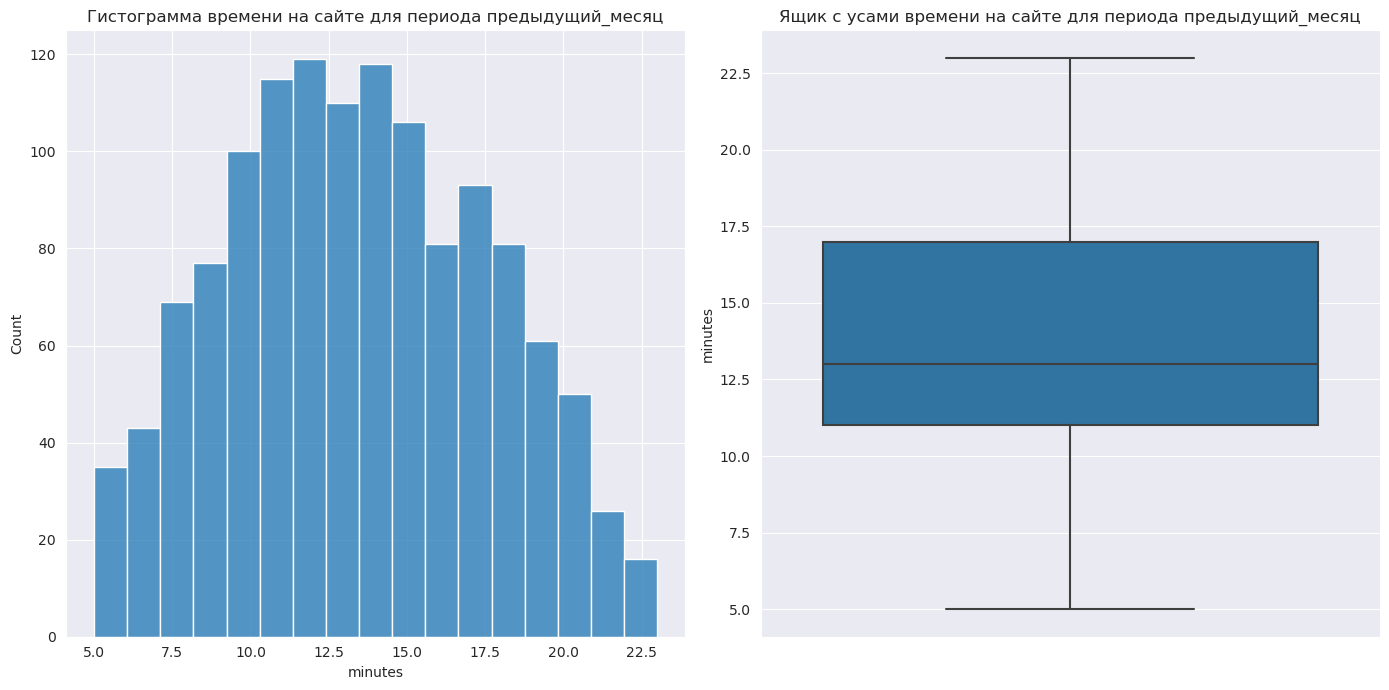

Статистика для периода предыдущий_месяц:


,minutes
count,1300.000000
mean,13.467692
std,3.932029
min,5.000000
25%,11.000000
50%,13.000000
75%,17.000000
max,23.000000


In [31]:
periods = market_time_data['period'].unique()

for period in periods:
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))

    data = market_time_data[market_time_data['period'] == period].drop(columns='id')

    sns.histplot(data=data, x='minutes', ax=axs[0])
    axs[0].set_title(f'Гистограмма времени на сайте для периода {period}')

    sns.boxplot(y=data['minutes'], ax=axs[1])
    axs[1].set_title(f'Ящик с усами времени на сайте для периода {period}')

    plt.tight_layout()
    plt.show()

    print(f'Статистика для периода {period}:')
    display(data.describe())

Проведу анализ датасета money_data.

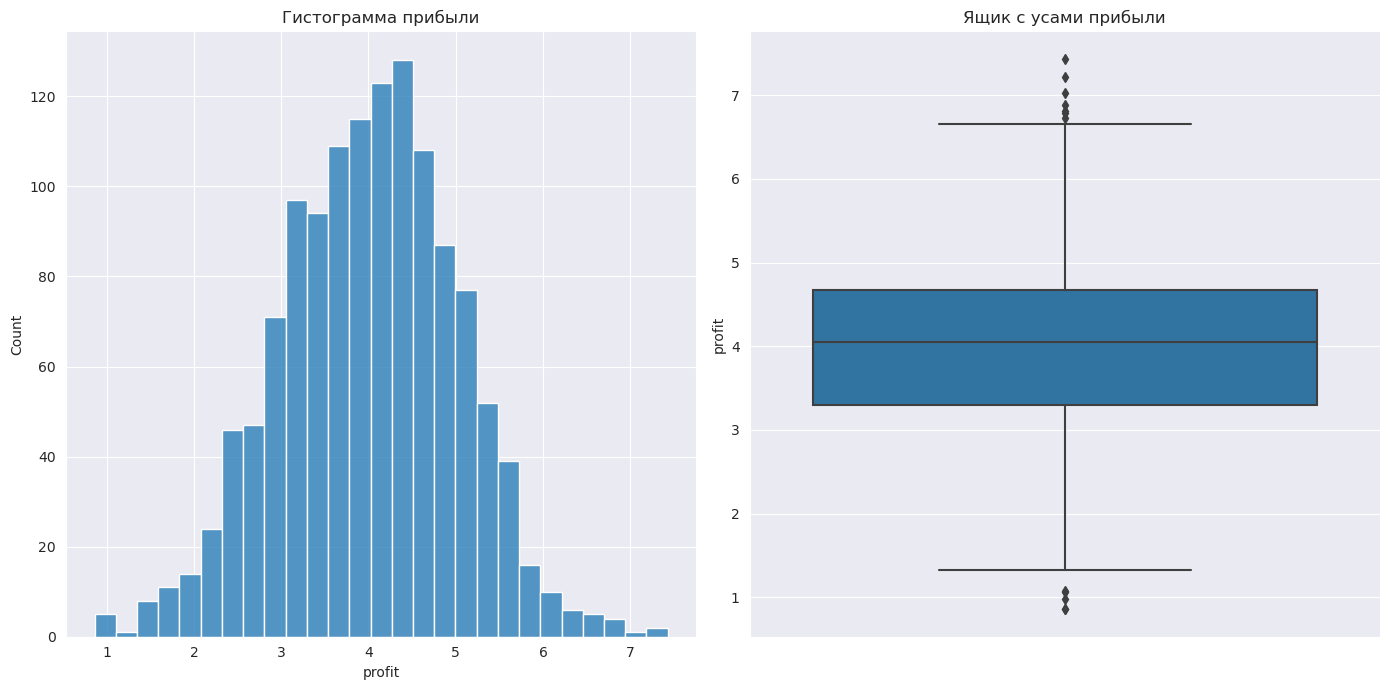

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

sns.histplot(data=money_data, x='profit', ax=axs[0])
axs[0].set_title('Гистограмма прибыли')

sns.boxplot(y=money_data['profit'], ax=axs[1])
axs[1].set_title('Ящик с усами прибыли')

plt.tight_layout()
plt.show()

## Объединение таблиц

## Корреляционный анализ

## Использование пайплайнов

## Анализ важности признаков

## Сегментация покупателей

## Общий вывод

Описание проекта
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 
Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Как решать задачу
Продумывать подход к решению этой задачи вам не придётся — руководитель отдела его уже сформировал:
Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».
Нужно собрать данные по клиентам по следующим группам:
Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.
Представим группы признаков (вместе с целевым) в виде диаграммы — такую визуализацию ещё называют диаграммой Исикавы.

Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.
Руководство одобрило описание решения, и вам, как специалисту по DS, нужно его реализовать.

Описание данных
Данные для работы находятся в нескольких таблицах. Нажмите на название файла, чтобы его скачать.
market_file.csv
Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
id — номер покупателя в корпоративной базе данных.
Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.
market_money.csv
Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
id — номер покупателя в корпоративной базе данных.
Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
Выручка — сумма выручки за период.
market_time.csv
Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
id — номер покупателя в корпоративной базе данных.
Период — название периода, во время которого зафиксировано общее время.
минут — значение времени, проведённого на сайте, в минутах.
money.csv
Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
id — номер покупателя в корпоративной базе данных.
Прибыль — значение прибыли.
Инструкция по выполнению проекта
Решать задачу вам нужно в два этапа:
Разработайте модель, которая предскажет вероятность снижения покупательской активности.
Выделите сегмент покупателей, проанализируйте его и предложите, как увеличить его покупательскую активность. Используйте данные моделирования, данные о прибыли покупателей и исходные данные (если понадобятся). По желанию вы можете проанализировать больше одного сегмента.

Ниже несколько примеров сегментов, но вы также можете выделить свой:

Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.
Группа клиентов, которые покупают только технику, то есть товары с длинным жизненным циклом.
Группа клиентов, которые покупают товары из категории «Товары для себя» (новая категория, которую можно выделить на основе текущих) или «Товары для детей».
Группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.
Шаг 1. Загрузка данных
1.1 Загрузите данные. Файлы market_file.csv, market_money.csv, market_time.csv, money.csv доступны по ссылкам в описании данных или через пути к ним:
/datasets/market_file.csv
/datasets/market_money.csv
/datasets/market_time.csv
/datasets/money.csv
Обратите внимание: в некоторых файлах разделитель значений — точка с запятой, а разделитель десятичных значений — запятая.  
1.2 Проверьте, что данные в таблицах соответствуют описанию. Исследованием и объединением данных вы займётесь позже.
Шаг 2. Предобработка данных
Проведите необходимую предобработку данных. Названия столбцов можно оставить кириллическими.
Шаг 3. Исследовательский анализ данных
Проведите исследовательский анализ данных из каждой таблицы. Отберите клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. Оформите выводы по результатам шага.
Шаг 4. Объединение таблиц
4.1 Объедините таблицы market_file.csv, market_money.csv, market_time.csv. Данные о прибыли из файла money.csv при моделировании вам не понадобятся. 
4.2 Учитывайте, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделайте отдельный столбец для каждого периода.
Шаг 5. Корреляционный анализ
Проведите корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделайте выводы о мультиколлинеарности и при необходимости устраните её.
Шаг 6. Использование пайплайнов
Примените все изученные модели. Для этого используйте пайплайны.
6.1 Во время подготовки данных используйте ColumnTransformer. Количественные и категориальные признаки обработайте в пайплайне раздельно. Для кодирования категориальных признаков используйте как минимум два кодировщика, для масштабирования количественных — как минимум два скейлера.
Напоминаем, что для каждой модели можно подготовить данные с разным кодированием и масштабированием.
6.2 Обучите четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(). Для каждой из них подберите как минимум один гиперпараметр. Выберите подходящую для задачи метрику, аргументируйте свой выбор. Используйте эту метрику при подборе гиперпараметров.
6.3 Выберите лучшую модель, используя заданную метрику. Для этого примените одну из стратегий:
использовать пайплайны и инструменты подбора гиперпараметров для каждой модели отдельно, чтобы выбрать лучшую модель самостоятельно;
использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернёт вам лучшую модель.
Шаг 7. Анализ важности признаков
7.1 Оцените важность признаков для лучшей модели и постройте график важности с помощью метода SHAP. 
7.2 Сделайте выводы о значимости признаков:
какие признаки мало значимы для модели;
какие признаки сильнее всего влияют на целевой признак;
как можно использовать эти наблюдения при моделировании и принятии бизнес-решений.
Шаг 8. Сегментация покупателей
8.1 Выполните сегментацию покупателей. Используйте результаты моделирования и данные о прибыльности покупателей.
8.2 Выберите группу покупателей и предложите, как увеличить её покупательскую активность: 
Проведите графическое и аналитическое исследование группы покупателей.
Сделайте предложения по работе с сегментом для увеличения покупательской активности.
8.3 Сделайте выводы о сегментах:
какой сегмент вы взяли для дополнительного исследования,
какие предложения вы сделали и почему.
Шаг 9. Общий вывод
Сделайте общий вывод:
опишите задачу;
опишите исходные данные и проведённую предобработку;
напишите, что вы сделали для поиска лучшей модели;
укажите лучшую модель;
добавьте выводы и дополнительные предложения для выбранного сегмента покупателей.